# Importing necessary libraries , data loading and EDA

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose 
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [2]:
df = pd.read_csv(r"D:\Stat TABA\Stat_Repeat\IncidentDriving.csv")

In [3]:
df.tail()

,Quarter,Type of Offence,VALUE
77,2022Q2,Dangerous driving causing serious bodily harm,14
78,2022Q3,Dangerous driving causing serious bodily harm,8
79,2022Q4,Dangerous driving causing serious bodily harm,15
80,2023Q1,Dangerous driving causing serious bodily harm,6
81,2023Q2,Dangerous driving causing serious bodily harm,5


In [4]:
df.size

246

In [5]:
print(df.columns)

Index(['Quarter', 'Type of Offence', 'VALUE'], dtype='object')


In [6]:
df['Type of Offence'].unique

<bound method Series.unique of 0     Dangerous driving causing serious bodily harm
1     Dangerous driving causing serious bodily harm
2     Dangerous driving causing serious bodily harm
3     Dangerous driving causing serious bodily harm
4     Dangerous driving causing serious bodily harm
                          ...                      
77    Dangerous driving causing serious bodily harm
78    Dangerous driving causing serious bodily harm
79    Dangerous driving causing serious bodily harm
80    Dangerous driving causing serious bodily harm
81    Dangerous driving causing serious bodily harm
Name: Type of Offence, Length: 82, dtype: object>

In [7]:
df['Quarter'] = pd.to_datetime(df['Quarter'])
df.set_index('Quarter', inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17572\4137946062.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Quarter'] = pd.to_datetime(df['Quarter'])


In [8]:
df.head()

,Type of Offence,VALUE
Quarter,,
2003-01-01,Dangerous driving causing serious bodily harm,4
2003-04-01,Dangerous driving causing serious bodily harm,4
2003-07-01,Dangerous driving causing serious bodily harm,9
2003-10-01,Dangerous driving causing serious bodily harm,3
2004-01-01,Dangerous driving causing serious bodily harm,13


In [9]:
df.tail()

,Type of Offence,VALUE
Quarter,,
2022-04-01,Dangerous driving causing serious bodily harm,14
2022-07-01,Dangerous driving causing serious bodily harm,8
2022-10-01,Dangerous driving causing serious bodily harm,15
2023-01-01,Dangerous driving causing serious bodily harm,6
2023-04-01,Dangerous driving causing serious bodily harm,5


In [10]:
# Count values in the 'VALUE' column that are equal to or less than zero
count_below_zero = (df['VALUE'] <=0).sum()

print(f"Number of values equal to or less than zero: {count_below_zero}")

Number of values equal to or less than zero: 2


In [11]:
df.isnull().sum()

Type of Offence    0
VALUE              0
dtype: int64

In [12]:
df.isna().sum()

Type of Offence    0
VALUE              0
dtype: int64

In [13]:
df.describe()

,VALUE
count,82.000000
mean,5.768293
std,4.083386
min,0.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,19.000000


### Use Augmented dicky-Fuller Test to check if the series is stationary

In [14]:
# Perform ADF test
result = adfuller(df['VALUE'])

# Extract and print ADF test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Interpret the results
if p_value <= 0.05:
    print('\nThe time series is likely stationary (reject the null hypothesis)')
else:
    print('\nThe time series is likely non-stationary (fail to reject the null hypothesis)')

ADF Statistic: -2.904213398367137
p-value: 0.04486022584569642
Critical Values:
   1%: -3.5148692050781247
   5%: -2.8984085156250003
   10%: -2.58643890625

The time series is likely stationary (reject the null hypothesis)


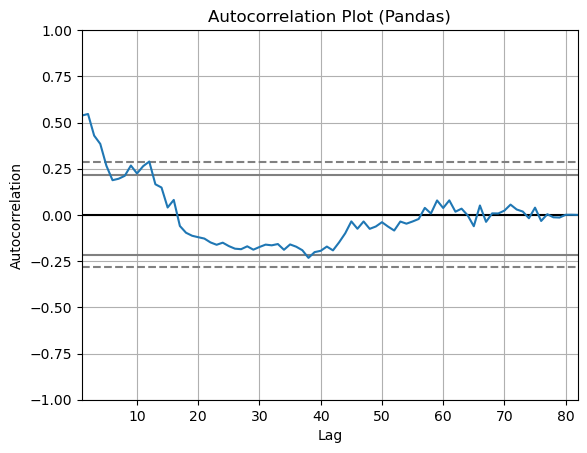

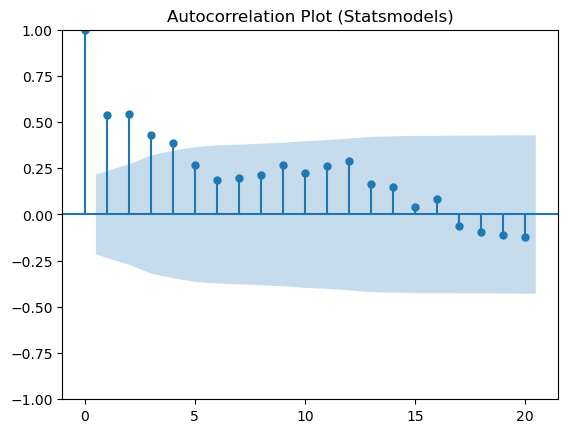

In [15]:
# Visualize autocorrelation using pandas
autocorrelation_plot(df['VALUE'])
plt.title('Autocorrelation Plot (Pandas)')
plt.show()

# Visualize autocorrelation using statsmodels
plot_acf(df['VALUE'])
plt.title('Autocorrelation Plot (Statsmodels)')
plt.show()

In [16]:
# Compute autocorrelation values
autocorr_values = acf(df['VALUE'], nlags=20)  # Adjust the number of lags as needed

# Print autocorrelation values
print('Autocorrelation Values:')
print(autocorr_values)

Autocorrelation Values:
[ 1.          0.5377168   0.54616471  0.42930223  0.38426884  0.26615128
  0.18790766  0.19577769  0.2116207   0.26722027  0.22423657  0.26378182
  0.28879873  0.16579624  0.14826649  0.04012644  0.08115252 -0.05980046
 -0.09635522 -0.11274726 -0.12058844]


### lets use seasonal decompose method to check stationarity,trends and seasonality in given series

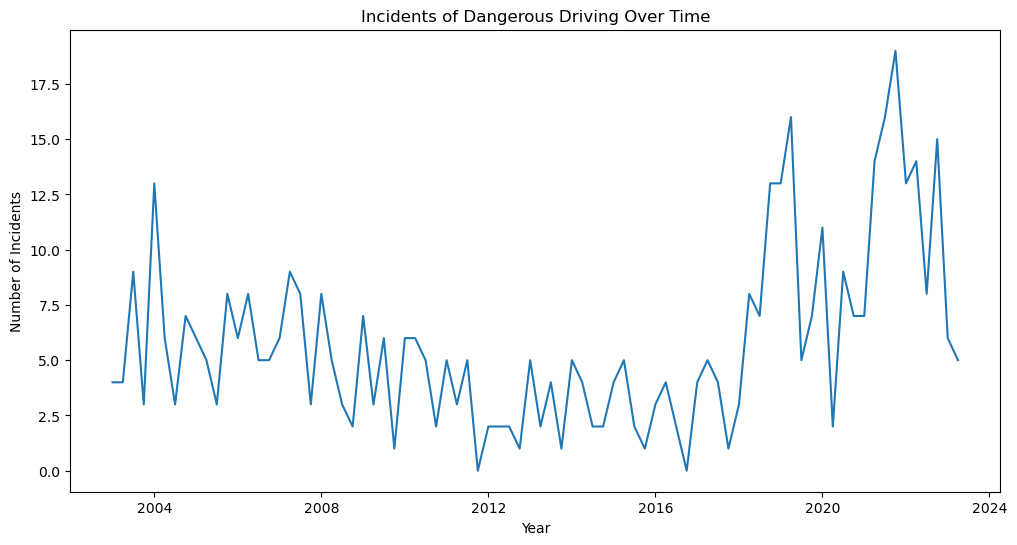

In [17]:
#figure no. 8 in report
# Time series plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['VALUE'])  
plt.title('Incidents of Dangerous Driving Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()

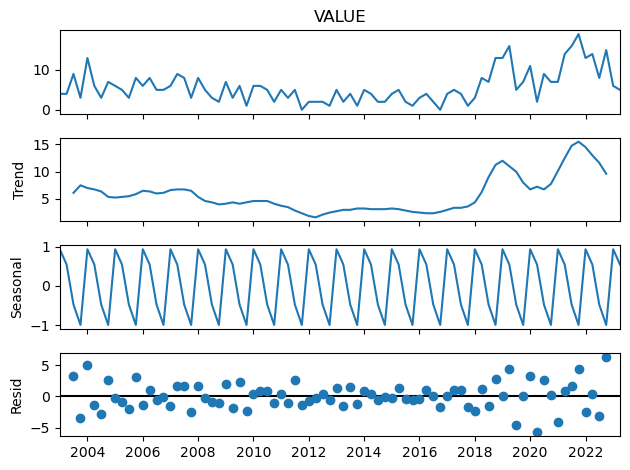

In [18]:
#figure no. 9 in report
# Decomposition plot
decomposition = seasonal_decompose(df['VALUE'], model='additive')
decomposition.plot()
plt.show()

Given series is stationary according to the AD-fuller test and sesonal decompose method shows evidence for additive sesonality with no trend.

# Evalute different time series models for given series

### Split data into training and testing sets

In [19]:

train_end_date = '2021-12-31'
train_data = df.loc[df.index <= train_end_date]
test_data = df.loc[df.index > train_end_date]

In [20]:
test_data

,Type of Offence,VALUE
Quarter,,
2022-01-01,Dangerous driving causing serious bodily harm,13
2022-04-01,Dangerous driving causing serious bodily harm,14
2022-07-01,Dangerous driving causing serious bodily harm,8
2022-10-01,Dangerous driving causing serious bodily harm,15
2023-01-01,Dangerous driving causing serious bodily harm,6
2023-04-01,Dangerous driving causing serious bodily harm,5


# Exponential Smoothing

Exponential smoothing for a time series is particularly useful for data with no clear trend or seasonality.
There are different variants of exponential smoothing:

1) Simple Exponential Smoothing (SES)- for no clear trnds and seasonality
2) Double Exponential Smoothing (Holt's method) - for level and trend components.
3) Triple Exponential Smoothing (Holt-Winters method) - for the level, trend, and seasonality components.
 
For given series, we will use Simple Exponential Smoothing as it is suitable for time series data with no clear trends and with additive seasonality.We will not be using later methods as they are useful for capturing both trends and seasonality.

In [21]:
model = ExponentialSmoothing(train_data['VALUE'], seasonal='add', seasonal_periods=4)
model_fit = model.fit()
forecast = model_fit.forecast(len(test_data))
 

C:\Program Files\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [22]:
actual_values = test_data['VALUE']

In [23]:
# Model Evaluation
def evaluate_forecast(actual, forecast):
    mse = mean_squared_error(actual, forecast)
    mae = mean_absolute_error(actual, forecast)
    return mse, mae

In [24]:
mse_exp_smoothing, mae_exp_smoothing = evaluate_forecast(test_data['VALUE'], forecast)

In [25]:
print(f"MSE for Simple Exponential Smoothing: {mse_exp_smoothing}")
print(f"MAE for Simple Exponential Smoothing: {mae_exp_smoothing}")

MSE for Simple Exponential Smoothing: 61.55515827370785
MAE for Simple Exponential Smoothing: 6.519891375241663


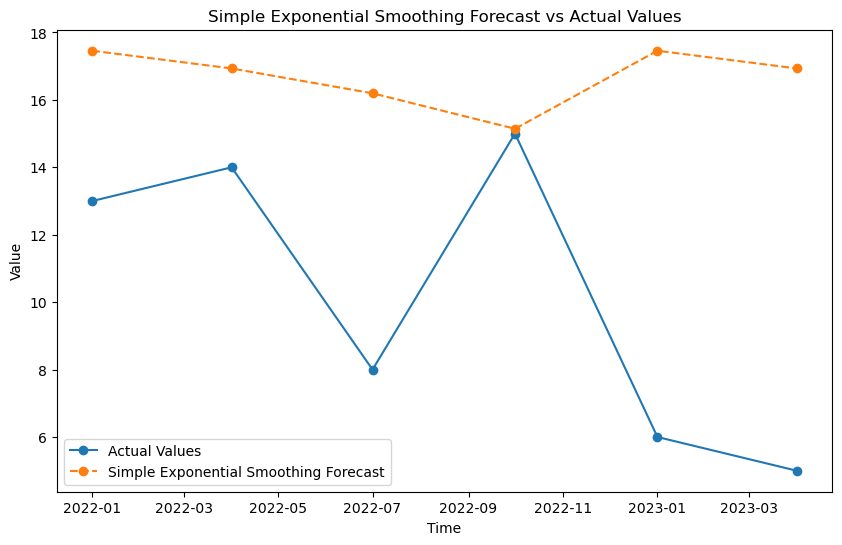

In [26]:
#figure no. 10 in report
actual_values = test_data['VALUE']

# Plot the actual values and the forecast
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Values', marker='o')
plt.plot(forecast, label='Simple Exponential Smoothing Forecast', linestyle='dashed', marker='o')
plt.title('Simple Exponential Smoothing Forecast vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Diagnostic Tests

##### Residual Analysis

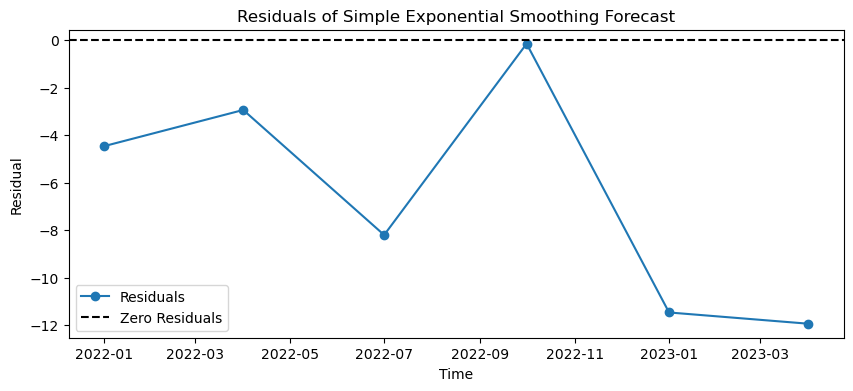

In [27]:
#figure no. 11 in report
# Calculate residuals
residuals_exp_smoothing = actual_values - forecast

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals_exp_smoothing, label='Residuals', marker='o')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals of Simple Exponential Smoothing Forecast')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()


There are systematic patterns (e.g., a trend or seasonal fluctuations) in the residuals, it suggests that the model may be missing some important information or that there may be some other underlying patterns in the data that the model cannot capture.

### ACF and PACF

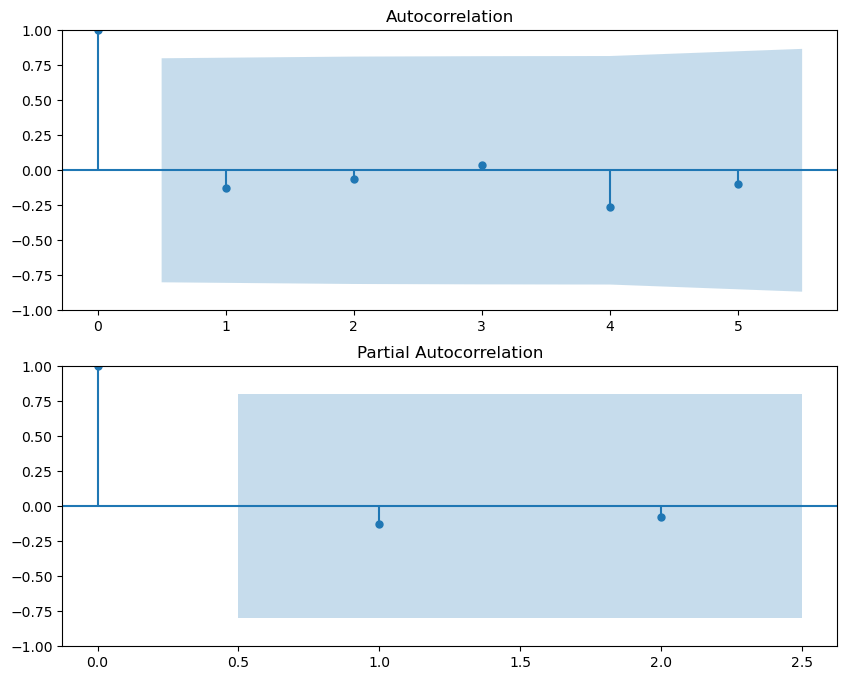

In [28]:
#figure no. 12 in report
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals_exp_smoothing, ax=ax1)
plot_pacf(residuals_exp_smoothing, lags=2, ax=ax2)  
plt.show()


The ACF and PACF function shows some correlations at one lag(i.e., the bars are outside the confidence interval) although very less, it suggests that there may be some underlying patterns in the residuals that the model cannot capture

##### Ljung-Box Test

In [29]:
sm.stats.acorr_ljungbox(residuals_exp_smoothing, lags=[5], return_df=True)

,lb_stat,lb_pvalue
5,2.280521,0.809123


Ljung-Box test with 5 lags resulted in a test statistic (lb_stat) of approximately 2.28 and a p-value (lb_pvalue) of approximately 0.809.
The Ljung-Box test is a statistical test for checking whether the residuals of a time series model are white noise.
The null hypothesis is that the residuals are independently distributed and the alternative hypothesis is that there is serial correlation among the residuals.
This measures of how much the observed autocorrelation values differ from the expected values under the assumption of no autocorrelation.since the p-value is greater than the common significance level of 0.05,we fail to reject the null hypothesis. This suggests that there is no strong evidence of autocorrelation in the residuals at the specified lags.

This suggests that the Simple Exponential Smoothing model may not be fully capturing the underlying patterns in the data, and there may be room for improvement in the model.

# ARIMA and SARIMA

ARIMA and SARIMA models are time series models that are used to capture the autocorrelation,non-stationarity, and seasonality 
of a time series. The models consist of three components: the autoregressive (AR) component, the integrated (I) component,
and the moving average (MA) component. The AR component models the linear dependence between an observation and a lagged value,
the MA component models the linear dependence between an observation and the residual error from a moving average model, 
and the I component is used to make a non-stationary series stationary by differencing. SARIMA models include an additional 
seasonal component that captures the seasonal patterns in the data.

#### ARIMA

(p,d,q) = (1,1,1)

In [30]:
p1 = 1
d1 = 1
q1 = 1

In [31]:
modelArima = ARIMA(train_data['VALUE'], order=(p1, d1, q1)).fit()

C:\Program Files\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Program Files\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Program Files\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [32]:
predictions1 = modelArima.predict(start=len(train_data) + 1, end=len(train_data)+len(test_data), typ='levels')

C:\Program Files\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [33]:
predictions1

2022-04-01    16.137955
2022-07-01    16.065003
2022-10-01    16.075758
2023-01-01    16.074172
2023-04-01    16.074406
2023-07-01    16.074372
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [34]:
mse_ARIMA, mae_ARIMA = evaluate_forecast(test_data['VALUE'], predictions1)

In [35]:
print(f"MSE for ARIMA: {mse_ARIMA}")
print(f"MAE for ARIMA: {mae_ARIMA}")

MSE for ARIMA: 50.769678212698786
MAE for ARIMA: 5.9169443185938375


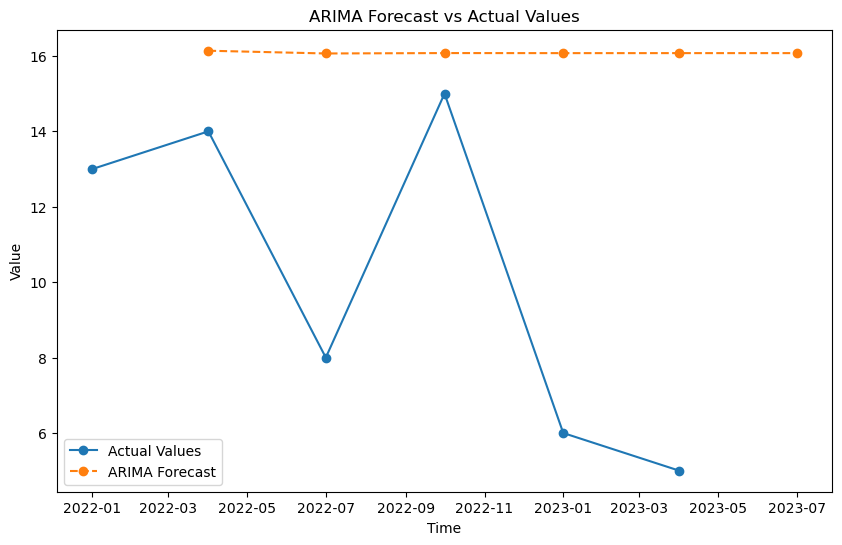

In [36]:
# Plot the actual values and the forecast
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Values', marker='o')
plt.plot(predictions1, label='ARIMA Forecast', linestyle='dashed', marker='o')
plt.title('ARIMA Forecast vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Diagnostic Tests

##### Residual Analysis

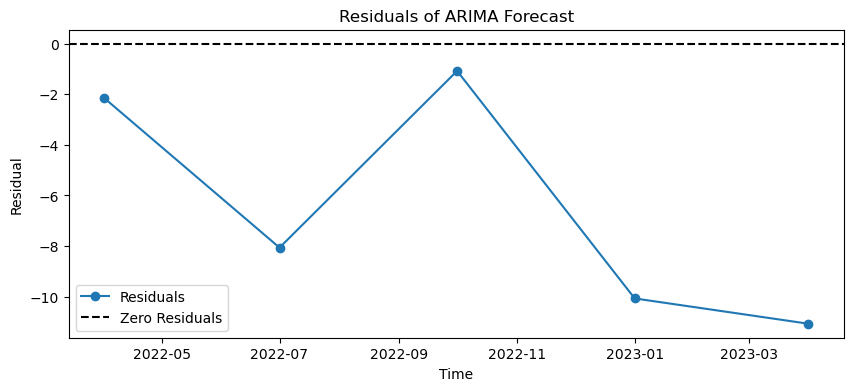

In [37]:
#figure no. 14 in report
# Calculate residuals
residuals_ARIMA = actual_values - predictions1

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals_ARIMA, label='Residuals', marker='o')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals of ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()


The seasonal pattern in the residuals could indicate that the model is not accounting for all the seasonality in the data,
leading to remaining patterns in the residuals. It may be necessary to revisit the model and consider adjustments to improve its 
performance.

##### ACF and PACF

C:\Program Files\Anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


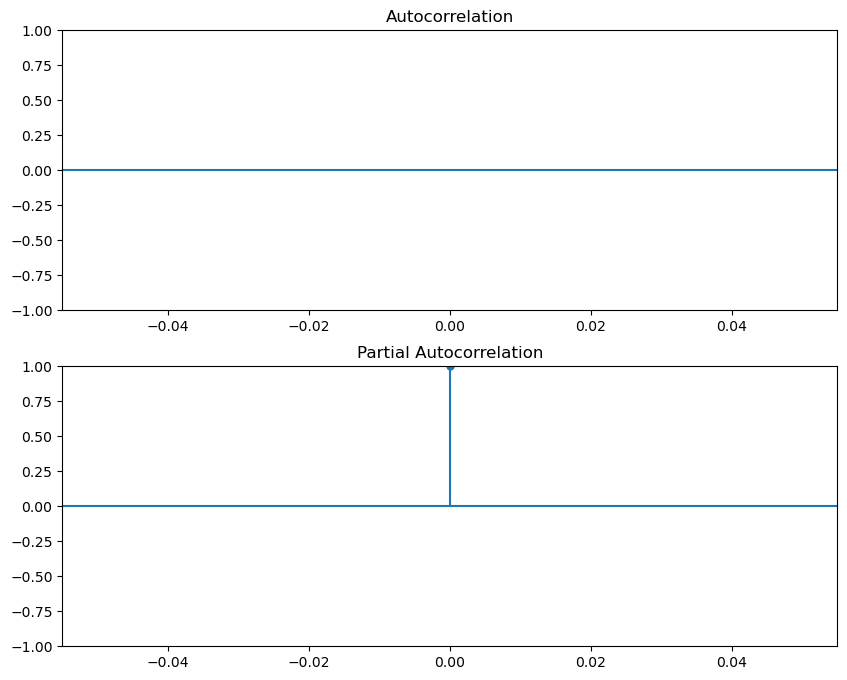

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
plot_acf(residuals_ARIMA, ax=ax1)
plot_pacf(residuals_ARIMA, lags=2.5, ax=ax2)
plt.show()

The ACF and PACF function shows one correlation at certain lag 0.The number of lags used here are very less(2).The PACF estimates become less reliable with fewer observations.We will other diagnostics such as Ljung-Box test for autocorrelation of residuals.

##### Ljung-Box Test

The Ljung-Box test is a statistical test for checking whether the residuals of a time series model are white noise. The null hypothesis is that the residuals are independently distributed and the alternative hypothesis is that there is serial correlation among the residuals.

In [39]:
sm.stats.acorr_ljungbox(residuals_ARIMA, lags=[6], return_df=True)

,lb_stat,lb_pvalue
6,NaN,NaN


### SARIMA

(p,d,q) = (1,1,1) and (P,D,Q,S) = (1,1,1,4)

In [40]:
p11 = 1
d11 = 1
q11 = 1
P11 = 1
D11 = 1
Q11 = 1
S11 = 4

In [41]:
modelSARIMA1 = SARIMAX(train_data['VALUE'], order=(p11, d11, q11), seasonal_order=(P11, D11, Q11, S11)).fit()

C:\Program Files\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Program Files\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [42]:
predictionsSARIMA1 = modelSARIMA1.predict(start=len(train_data) + 1, end=len(train_data)+len(test_data), typ='levels')

C:\Program Files\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [43]:
mse_SARIMA, mae_SARIMA = evaluate_forecast(test_data['VALUE'], predictionsSARIMA1)

In [44]:
print(f"MSE for Seasonal ARIMA: {mse_ARIMA}")
print(f"MAE for Seasonal ARIMA {mae_ARIMA}")

MSE for Seasonal ARIMA: 50.769678212698786
MAE for Seasonal ARIMA 5.9169443185938375


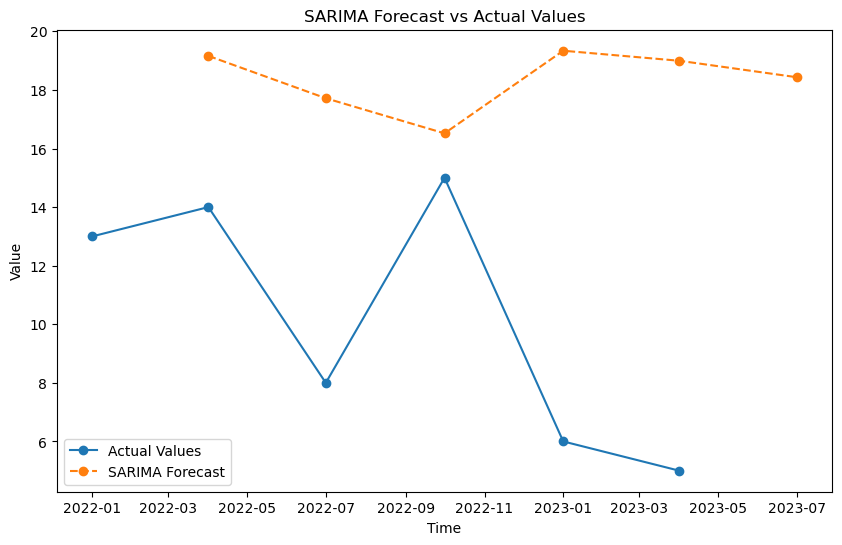

In [45]:
#figure no. 13 in report
# Plot the actual values and the forecast
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Values', marker='o')
plt.plot(predictionsSARIMA1, label='SARIMA Forecast', linestyle='dashed', marker='o')
plt.title('SARIMA Forecast vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Diagnostic Tests

##### Residual Analysis

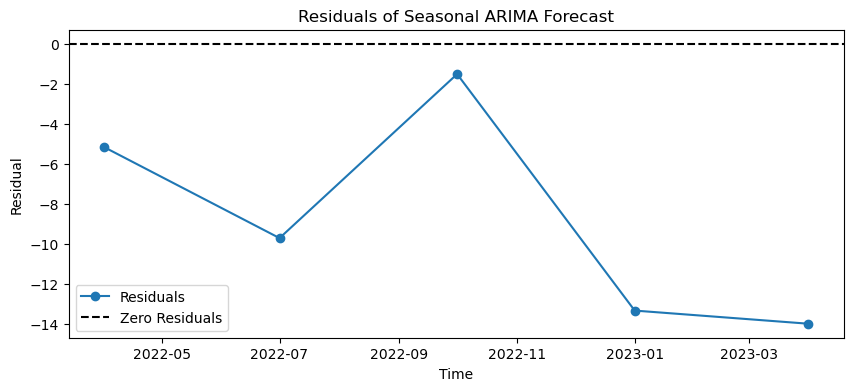

In [46]:
#figure no. 15 in report
# Calculate residuals
residuals_SARIMA = actual_values - predictionsSARIMA1

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals_SARIMA, label='Residuals', marker='o')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals of Seasonal ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

There are systematic patterns (e.g., a trend or seasonal fluctuations) in the residuals, it suggests that the model may be missing some important information or that there may be some other underlying patterns in the data that the model cannot capture.

##### ACF and PACF

C:\Program Files\Anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


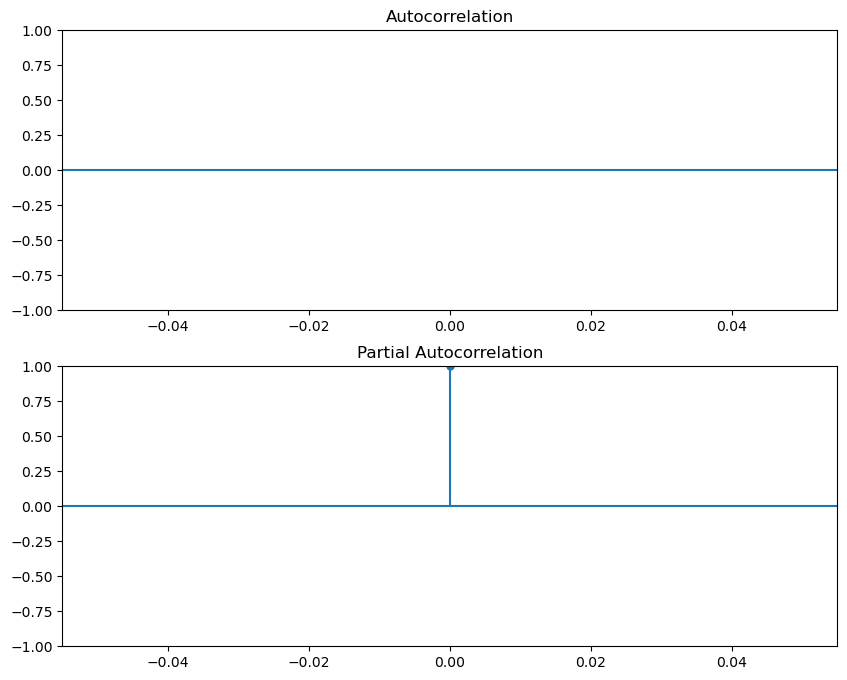

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
plot_acf(residuals_SARIMA, ax=ax1)
plot_pacf(residuals_SARIMA,lags=2, ax=ax2)
plt.show()

We got the same autocorrelation plot as ARIMA model.

##### Ljung-Box Test

In [48]:
sm.stats.acorr_ljungbox(residuals_SARIMA, lags=[2], return_df=True)

,lb_stat,lb_pvalue
2,NaN,NaN


## Simple Time Series Models

Simple Time Series Models typically include methods that use basic statistical techniques to make forecasts. These models are appropriate when the time series data does not exhibit complex patterns, such as trends or seasonality. Here are two common types of simple time series models:

Moving Averages (MA):A moving average is calculated by taking the average of a set of data points within a moving window of fixed size.
Naive Method - the forecast for the next period is the actual value of the current period.
Drift Method - the forecast for the next period is a linear extrapolation of the trend observed in the data.

#### Moving Average Method

In [49]:
# Simple Time Series Models
def simple_time_series(train, test):
    window_size = 4  # Quarterly data
    forecast = train.rolling(window=window_size).mean().iloc[-1]

    return pd.Series([forecast] * len(test), index=test.index)

In [50]:
# Simple Time Series Models Forecast
forecast_simple = simple_time_series(train_data['VALUE'], test_data['VALUE'])

In [51]:
mse_simple, mae_simple = evaluate_forecast(test_data['VALUE'], forecast_simple)

In [52]:
print(f"MSE for Simple Time series - Moving average method: {mse_simple}")
print(f"MAE for for Simple Time series - Moving average method {mae_simple}")

MSE for Simple Time series - Moving average method: 30.5
MAE for for Simple Time series - Moving average method 4.166666666666667


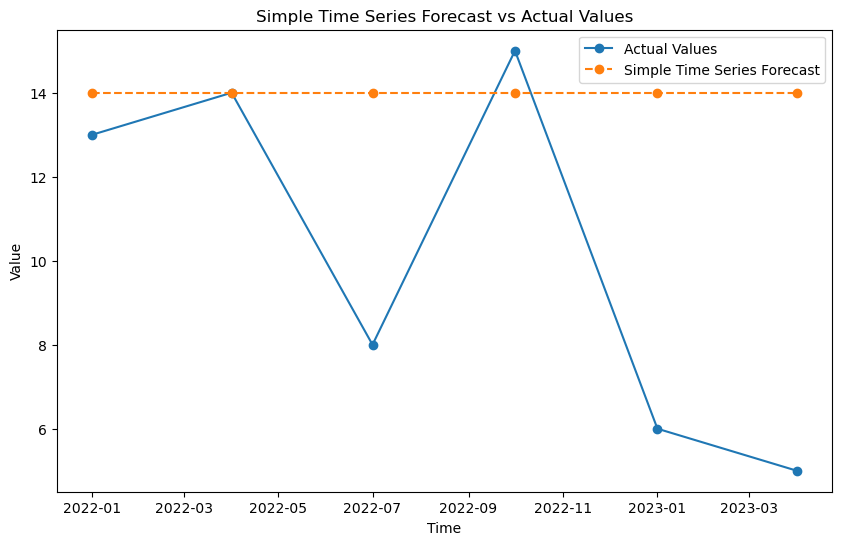

In [53]:
#figure no. 16 in report
# Plot the actual values and the forecast
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Values', marker='o')
plt.plot(forecast_simple, label='Simple Time Series Forecast', linestyle='dashed', marker='o')
plt.title('Simple Time Series Forecast vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Diagnostic Tests


##### Residual Analysis

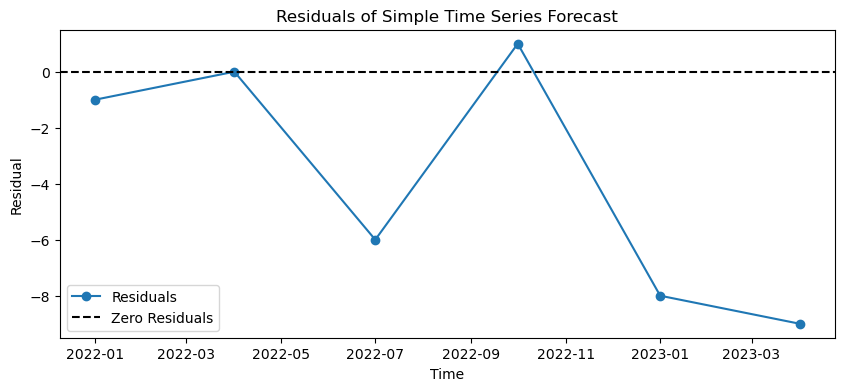

In [54]:
#figure no. 17 in report
# Calculate residuals
residuals_Simple = actual_values - forecast_simple

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals_Simple, label='Residuals', marker='o')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals of Simple Time Series Forecast')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

Residuals still exihibit patterns indicating possibility of seasonality and trend.Other diagnostics should be taken to check for the model fit. 

##### ACF and PACF

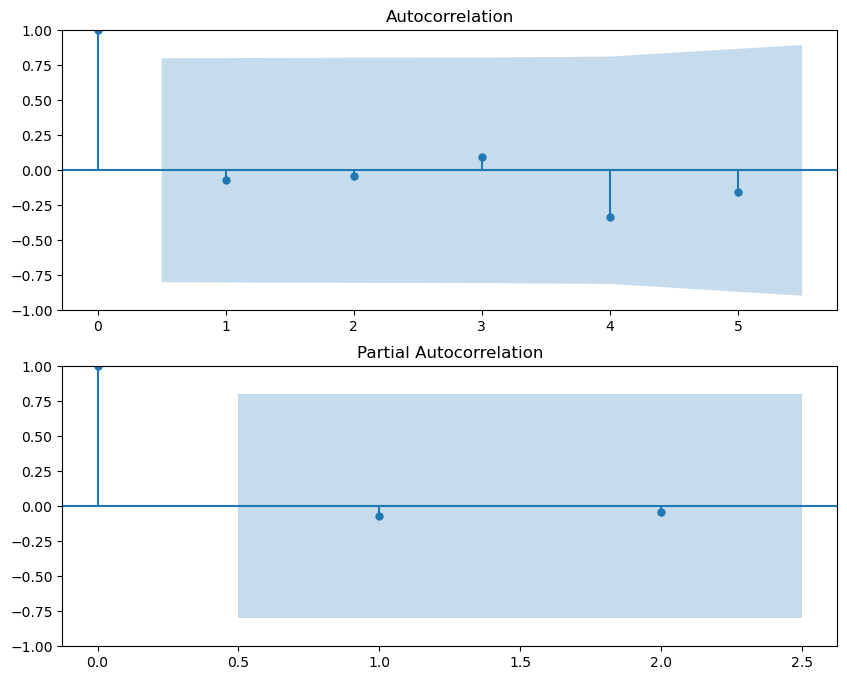

In [55]:
##figure no. 18 in report
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
plot_acf(residuals_Simple, ax=ax1)
plot_pacf(residuals_Simple,lags=2, ax=ax2)
plt.show()

Additionally, you can see a blue area in the ACF and PACF plots. This blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.There’s only one autocorrelation that is significantly non-zero at a lag of 0. Therefore, the time series is random.

##### Ljung-Box Test

In [56]:
sm.stats.acorr_ljungbox(residuals_Simple, lags=[2], return_df=True)

,lb_stat,lb_pvalue
2,0.062355,0.969304


These results suggest that there is no significant autocorrelation in the residuals, and we do not have evidence to reject the null hypothesis. It's a good sign, indicating that the residuals are behaving like white noise, and our model might be a good fit.